In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.constants as cst
import astropy.units as u
from heapq import nsmallest
from scipy.signal import find_peaks
from functions import vac2air_ciddor
from scipy.interpolate import interp1d
from lmfit.models import VoigtModel
from edibles.utils.voigt_profile import voigt_absorption_line
from lmfit import Model
from edibles.utils.ContinuumFitter import ContinuumFitter

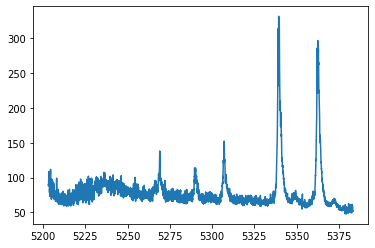

In [2]:
acenap = np.loadtxt("PENTACENE.DAT", skiprows=1).transpose()
#np.set_printoptions(threshold=np.inf)
#print(methnap)
acenap[0] = (1/acenap[0])*(10**8)         # converting from wno to wavelength in Angstrom
plt.plot(acenap[0], acenap[1])
plt.show()
data=acenap

datamol = data

datamol[0,:]=vac2air_ciddor(data[0,:])


In [3]:
cf1 = ContinuumFitter(datamol[0,:], datamol[1,:])
cf11, pts = cf1.SplineManualAnchor()


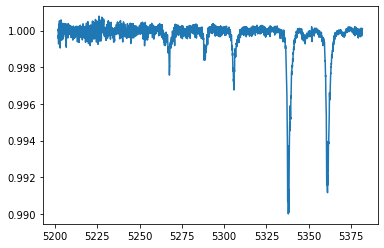

In [4]:
datamol[1,:]=1-0.01*(data[1,:]-(cf11(datamol[0,:])))/(np.max(data[1,:])-cf11(datamol[0, data[1,:] == np.max(data[1,:])]))

plt.plot(datamol[0,:], datamol[1,:])

In [5]:
cf2 = ContinuumFitter(datamol[0,:], datamol[1,:])
cf22 = cf2.SelectPoints(n=100, y_message=None)[:,0]

peaks = np.reshape(cf22, (int(cf22.size/2),2))
print(peaks)

[[5261.92688473 5271.71929516]
 [5284.60124324 5293.61897564]
 [5301.22328001 5310.7652764 ]
 [5329.99977771 5344.42265363]
 [5354.40601853 5369.05700968]]


In [6]:
# Calculating standard deviation to calculate the noise in the data
sdar = datamol

for i3 in range(peaks.shape[0]):
    sdar = np.delete(sdar, np.logical_and(sdar[0,:]>=peaks[i3,0], sdar[0,:]<=peaks[i3,1]),1)
    
sd = np.std(sdar[1,:])
print(sd)

0.00021679596789009952


In [7]:
# Function for voigt fitting the peaks of entire spectra
# input parameters: file_name, array of start & end points of peak, standard deviation


def voigtmultipeak(fdata, rang, sd):
    ar2={}
    No_Peaks=rang.shape[0]
    for i2 in range(No_Peaks):
        xfit_m = fdata[0, np.logical_and(fdata[0,:]>=rang[i2,0], fdata[0,:]<=rang[i2,1])]
        yfit_m = 1 - fdata[1, np.logical_and(fdata[0,:]>=rang[i2,0], fdata[0,:]<=rang[i2,1])]
        mod = VoigtModel()
        par = mod.guess(yfit_m, x=xfit_m)
        res = mod.fit(yfit_m, par, weights=1/sd, x=xfit_m)
        plt.plot(xfit_m, 1-res.best_fit, label='Fitted peak'+str(i2+1))
    
        cenkey = 'Center' + str(i2+1)
        fwhmkey = 'Fwhm' + str(i2+1)
        chisqkey = 'ChiSqr' + str(i2+1)
        rchisqkey = 'RedChiSqr' + str(i2+1)
        ar2.update({cenkey: res.params['center'].value})
        ar2.update({fwhmkey: res.params['fwhm'].value})
    ar2.update({'ChiSq': res.chisqr})
    ar2.update({'RedChiSq': res.redchi})
        
    return ar2

{'Center1': 5267.564808036206, 'Fwhm1': 2.028702434892185, 'Center2': 5288.72988101239, 'Fwhm2': 1.6387456476344424, 'Center3': 5305.717284909737, 'Fwhm3': 1.8555536884738517, 'Center4': 5338.130927639194, 'Fwhm4': 2.030956518162682, 'Center5': 5361.254061297251, 'Fwhm5': 2.1289081316367953, 'ChiSq': 2029.815487557807, 'RedChiSq': 3.311281382639163}


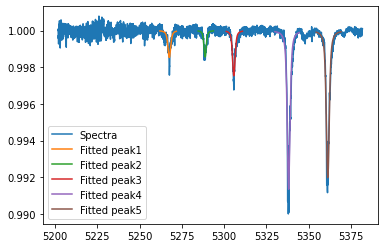

In [8]:
plt.plot(datamol[0,:],datamol[1,:], label='Spectra')
pk_fit_par = voigtmultipeak(datamol, peaks, sd)
plt.legend()
print(pk_fit_par)

In [9]:
stack_par = np.zeros((peaks.shape[0],2))

for i4 in range(peaks.shape[0]):
    p1 = 'Center' + str(i4+1)
    p2 = 'Fwhm' + str(i4+1)
    stack_par[i4,0] = pk_fit_par[p1]
    stack_par[i4,1] = pk_fit_par[p2]
    
print(stack_par)

[[5.26756481e+03 2.02870243e+00]
 [5.28872988e+03 1.63874565e+00]
 [5.30571728e+03 1.85555369e+00]
 [5.33813093e+03 2.03095652e+00]
 [5.36125406e+03 2.12890813e+00]]


In [10]:
#Function for Spectral stacking, which takes in the input as filename and array having info about start and end points of peak. 

def spectral_stacker_voigt(fdata,peaks):
    
    No_Peaks = peaks.shape[0]
    fpeaks = np.empty(shape=No_Peaks, dtype=object)
    
    ffig, faxs = plt.subplots(3, 2, figsize=(12,15))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    faxs[0,0].plot(fdata[0, :], fdata[1, :])
    faxs[0,0].set_title('Lab Spectrum')
    faxs[0,0].set(xlabel = 'Wavelength (Å)', ylabel = 'Relative intensity')
    
    
    # Creating separate arrays for each absorption in the spectra
    for i1 in range(No_Peaks):
        fpeaks[i1] = fdata[:,np.logical_and(fdata[0,:]>=peaks[i1,0]-2*peaks[i1,1], fdata[0,:]<=peaks[i1,0]+2*peaks[i1,1])]
        p = 'Peak'+str(i1+1)
        faxs[0,1].plot(fpeaks[i1][0,:], fpeaks[i1][1,:], label=p)
    faxs[0,1].set_title('Peaks')
    faxs[0,1].set(xlabel = 'Wavelength (Å)', ylabel = 'Relative intensity')
    faxs[0,1].legend()
    
    fDshft = fpeaks
    for j1 in range (No_Peaks):
        fDshft[j1][0,:] = fpeaks[j1][0,:]-peaks[j1,0]
        fDshft[j1][1,:] = fpeaks[j1][1,:]
        shp = 'Peak ' + str(j1+1)
        faxs[1, 0].plot(fDshft[j1][0,:], fDshft[j1][1,:], label = shp)
        
    faxs[1,0].set_title('Spectrum with peaks shifted')
    faxs[1,0].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[1,0].legend()
    
    fpoints = fDshft[0].shape[1]
    fstart = np.min(fDshft[0][0,:])
    fend = np.max(fDshft[0][0,:])
    for k1 in range(No_Peaks):
        if fDshft[k1].shape[1]>fpoints:
            fpoints = fDshft[k1].shape[1]
        if np.min(fDshft[k1][0,:]) > fstart:
            fstart = np.min(fDshft[k1][0,:])
        if np.max(fDshft[k1][0,:]) < fend:
            fend = np.max(fDshft[k1][0,:])
    fwavelength = np.linspace(fstart, fend, num = fpoints)  
    
            
    fitpn = np.empty(shape=No_Peaks, dtype=object)  
    for l1 in range(No_Peaks):
        fitpn[l1] = interp1d(fDshft[l1][0,:], fDshft[l1][1,:])
        
        
    ffin = np.zeros((2, fpoints))
    ffin[0,:] = fwavelength
    
    for m1 in range(No_Peaks):
        ffin[1,:] = ffin[1,:]+(fitpn[m1](fwavelength)/No_Peaks)
        pk1 = 'Peak' +str(m1+1)
        faxs[1,1].plot(fwavelength, fitpn[m1](fwavelength), label=pk1)         
        faxs[2,0].plot(fwavelength, fitpn[m1](fwavelength),label=pk1)
    faxs[1,1].set_title('Interpolated Peaks having same widths')
    faxs[1,1].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[1,1].legend()
    faxs[2,0].set_title('Interpolated Peaks with the stacked peak')
    faxs[2,0].set(xlabel = 'Relative Wavelength (Å) (shifted by peak)', ylabel = 'Relative intensity')
    faxs[2,0].legend()
        
    faxs[2,0].plot(ffin[0,:], ffin[1,:], label='Stacked spectra')
    faxs[2,0].legend()
    faxs[2,1].plot(ffin[0,:], ffin[1,:], label = 'Final Stacked peak')
    faxs[2,1].set_title('Only Stacked peak')
    faxs[2,1].set(xlabel = 'Relative Wavelength (Å)(shifted by peak)', ylabel = 'Relative intensity')
    faxs[2,1].legend()
    plt.subplots_adjust(hspace=0.3, wspace=0.2)

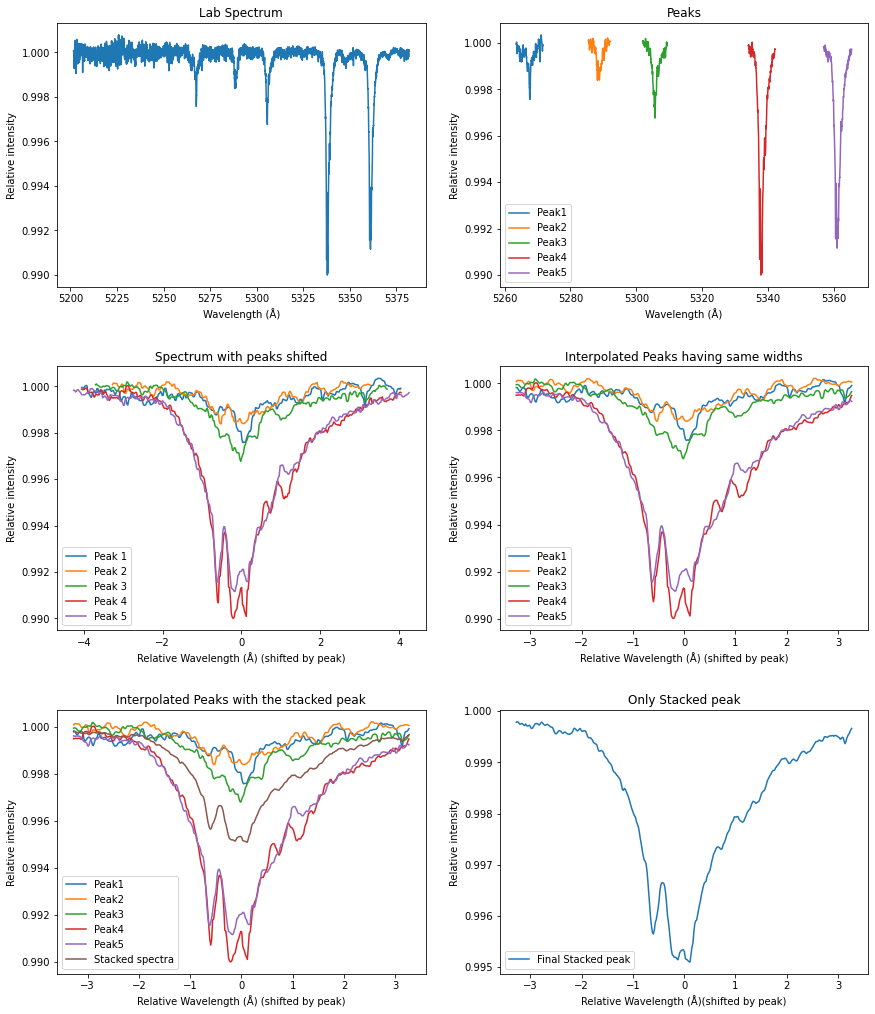

In [11]:
spectral_stacker_voigt(datamol, stack_par)